# A. Informationen zum Notebook

<p>Herausgeber: Koordinierungsstelle Bildungsmonitoring (KOSMO)</p>
<p>Version: 1.0.0 (XX.XX.2023)<p/>

<p>Dieses Notebook dient dazu, Gemeindedaten der Bundesagentur fuer Arbeit (BA) mit Bevoelkerungsdaten des Statistischen Bundesamtes (Destatis) zu verknuepfen, um daraus gemeindespezifische SGB-II-Quoten berechnen zu koennen. Hierbei wird auf folgende Originaldaten der BA und von Destatis zugegriffen, die von den entsprechenden Stellen bezogen werden koennen: </p>

- Statistik der Bundesagentur fuer Arbeit, Auftragsnummer 338634, Teil 1-5 (Eckwerte der Grundsicherung nach Gemeinden, Gebietsstand Dezember des jeweiligen Jahres, Jahresdurchschnittswerte, Datenstand: Maerz 2023, Daten zu Leistungen nach dem SGB II nach einer Wartezeit von 3 Monaten)
- Statistisches Bundesamt (Destatis), Bevoelkerungszahlen auf Gemeindeebene nach Geschlecht und Alter (Fortschreibung Zensus 2011, Stichtagsdaten zum 31.12. fuer Gebietsstand und Bevoelkerungszahl des jeweiligen Berichtsjahres (2014-2021)) 

Um die Aufbereitung der Daten korrekt durchfuehren zu koennen, muessen diese Notebook-Datei (.ipynb) sowie die Originaldaten bzw. -dateien der BA und von Destatis in einem lokalen Ordner gespeichert werden.

# 0. Vorbereitung der Daten

In [1]:
# Benoetigte Pakete importieren
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Hinweis: die folgende Bibliothek muss manuell installiert werden
from mapclassify import NaturalBreaks
from mapclassify import FisherJenksSampled
from mapclassify import FisherJenks

# Warnmeldungen unterdruecken
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Begrenzung der Spaltendarstellung deaktivieren
pd.set_option("display.max_columns", None)

In [3]:
# Einlesen der Gemeindedaten der Bundesagentur fuer Arbeit (BA) aus den Jahren 2014 bis 2021

# Dateinamen und Tabellennamen abrufen
file_names = [
    ("230328_EA_338634_Gemeindedaten_Teil1.xlsx", "2014"),
    ("230328_EA_338634_Gemeindedaten_Teil2.xlsx", "2015"),
    ("230328_EA_338634_Gemeindedaten_Teil2.xlsx", "2016"),
    ("230328_EA_338634_Gemeindedaten_Teil3.xlsx", "2017"),
    ("230328_EA_338634_Gemeindedaten_Teil3.xlsx", "2018"),
    ("230328_EA_338634_Gemeindedaten_Teil4.xlsx", "2019"),
    ("230328_EA_338634_Gemeindedaten_Teil4.xlsx", "2020"),
    ("230328_EA_338634_Gemeindedaten_Teil5.xlsx", "2021")
]

# Dictionary fuer die Dataframes erstellen
dataframes = {}

# Ueber Dateien und Tabellennamen iterieren
for file_name, sheet_name in file_names:
    # Spezifisches Tabellenblatt in einen DataFrame einlesen
    df = pd.read_excel(file_name, sheet_name=sheet_name)
    # DataFrame im Dictionary speichern
    dataframes["ba_" + sheet_name] = df

# Zugriff auf die Dataframes
ba_2014 = dataframes["ba_2014"]
ba_2015 = dataframes["ba_2015"]
ba_2016 = dataframes["ba_2016"]
ba_2017 = dataframes["ba_2017"]
ba_2018 = dataframes["ba_2018"]
ba_2019 = dataframes["ba_2019"]
ba_2020 = dataframes["ba_2020"]
ba_2021 = dataframes["ba_2021"]

# 1. BA-Daten umformen

### 1.1 Grundlegende Umformung der Ausgangsdaten

In [4]:
# Funktion zur Transformation der Daten definieren
def transform_dataframe(df):
    # Zeilen 0 bis 7 entfernen
    df = df.drop(df.index[0:7])
    
    # Letzte Zeile entfernen
    df = df.drop(df.index[-1])
    
    # Spalte 'Unnamed: 0' nach Leerzeichen trennen und in neue Spalten 'AGS' und 'Gemeinde' aufteilen
    df[['AGS', 'Gemeinde']] = df['Unnamed: 0'].str.split(' ', 1, expand=True)
    
    # Spalte 'Unnamed: 0' entfernen
    df = df.drop(['Unnamed: 0'], axis=1)
    
    # Erstellen einer Kontrollspalte 'Gesamtwerte_Kontrolle' mit den Spalten 'AGS', 'Gemeinde' und 'Unnamed: 1'
    Gesamtwerte_Kontrolle = df[['AGS', 'Gemeinde', 'Unnamed: 1']].copy()
    
    # Spalte 'Unnamed: 1' entfernen
    df.drop(['Unnamed: 1'], axis=1, inplace=True)
    
    # Nur Spalten ab der 23. Spalte behalten
    df = df.iloc[:, 23:]
    
    # Fehlende Werte in Zeile 5 mit den Werten der vorherigen Zeilen fuellen
    df.iloc[5] = df.iloc[5].fillna(df.iloc[4])
    df.iloc[5] = df.iloc[5].fillna(df.iloc[3])
    df.iloc[5] = df.iloc[5].fillna(df.iloc[2])
    
    # Zeilen 7, 9, 10, 11 und 13 entfernen
    df = df.drop([7, 9, 10, 11, 13])
    
    # Letzte beiden Werte in Zeile 1 mit den Werten der letzten beiden Spaltennamen fuellen
    df.iloc[1, -1] = df.columns[-1]
    df.iloc[1, -2] = df.columns[-2]
    
    # Neue Spaltennamen aus Zeile 1 erstellen
    new_columns = df.iloc[1].tolist()
    
    # Spaltennamen aktualisieren
    df = df.set_axis(new_columns, axis=1, inplace=False)
    
    # Zeile 12 entfernen
    df = df.drop(12)
    
    # Transformiertes DataFrame zurueckgeben
    return df

# Definierte Funktion auf die Daten anwenden und damit Dataframes erstellen
ba_2014 = transform_dataframe(ba_2014)
ba_2015 = transform_dataframe(ba_2015)
ba_2016 = transform_dataframe(ba_2016)
ba_2017 = transform_dataframe(ba_2017)
ba_2018 = transform_dataframe(ba_2018)
ba_2019 = transform_dataframe(ba_2019)
ba_2020 = transform_dataframe(ba_2020)
ba_2021 = transform_dataframe(ba_2021)

### 1.2 Spalte fuer Geschlecht ergaenzen und Tabelle entsprechend stapeln

In [5]:
# Funktion zur Transformation der Daten definieren
def apply_transformation(df):
    # Daten (maennlich) aus den ersten 24 Spalten und den Spalten 48 und 49 extrahieren
    df_m = df.iloc[:, list(range(24)) + [48, 49]]
    
    # Daten (weiblich) aus den Spalten 24 bis 49 extrahieren
    df_w = df.iloc[:, 24:50]
    
    # Geschlecht fuer Daten (weiblich) auf "w" setzen
    df_w.loc[:, "Geschlecht"] = "w"
    
    # Geschlecht fuer Daten (maennlich) auf "m" setzen
    df_m.loc[:, "Geschlecht"] = "m"
    
    # Zeile 8 aus Daten (weiblich) entfernen
    df_w = df_w.drop([8])
    
    # Zeile 8 aus Daten (maennlich) entfernen
    df_m = df_m.drop([8])
    
    # Daten (maennlich und weiblich) zu einem DataFrame kombinieren
    combined_df = df_m.append(df_w, ignore_index=True)
    
    # Spalten umbenennen, indem Bindestriche "-" entfernt werden
    combined_df = combined_df.rename(columns=lambda x: x.replace('-', ''))
    
    return combined_df

# Definierte Funktion auf die Daten anwenden und damit Dataframes transformieren
ba_2014_combined = apply_transformation(ba_2014)
ba_2015_combined = apply_transformation(ba_2015)
ba_2016_combined = apply_transformation(ba_2016)
ba_2017_combined = apply_transformation(ba_2017)
ba_2018_combined = apply_transformation(ba_2018)
ba_2019_combined = apply_transformation(ba_2019)
ba_2020_combined = apply_transformation(ba_2020)
ba_2021_combined = apply_transformation(ba_2021)

### 1.3 Gestapelte Zieltabellen erstellen:

 - Ein Dataframe (DF) mit Leistungsberechtigten (LB) nach Geschlecht und Altersgruppen, das sich auf Anzahl der LB aggregieren laesst
     - Spalte "LB unter 15 Jahren" loeschen, da aus anderen Spalten summierbar
     - Spalte "LB unter 65 Jahren" loeschen, da aus anderen Spalten summierbar 
     - Spalte "15 bis unter 18 Jahren (Kinder)" loeschen
 - Ein DF mit arbeitssuchenden erwerbsfaehigen Leistungsberechtigten (ELB) nach Geschlecht und Schulabschluessen (Unterscheidung Schulabschluesse nur fuer "arbeitssuchende ELB" moeglich)
     - Spalten 15 - 20 in der Ausgangsdatei
 - Ein DF mit arbeitssuchenden ELB nach Geschlecht und Berufsausbildung (Unterscheidung Berufsausbildung nur fuer "arbeitssuchende ELB" moeglich)
     - Spalten 21- 24 in der Ausgangsdatei

In [6]:
# Funktion zur Transformation der Daten definieren
def apply_transformation(df, year):
    # relevante Spalten aus dem kombinierten Dataframe extrahieren
    LB_nach_Altersgruppen = df.iloc[:, [3, 4, 5, 6, 7, 8, 24, 25, 26]].copy()

    # Datensatz in langes Format umwandeln, indem Altersgruppen in separate Spalte transformiert werden
    LB_nach_Altersgruppen = pd.melt(LB_nach_Altersgruppen, id_vars=['AGS', 'Gemeinde', 'Geschlecht'], value_vars=['unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren', '15 bis unter 18 Jahren', '18 bis unter 25 Jahren', '25 bis unter 65 Jahren'], var_name='Altersgruppe', value_name='Anzahl')

    # Spalte hinzufuegen, um das Jahr zu speichern
    LB_nach_Altersgruppen['Jahr'] = year

    # Spalten "AGS" und "Jahr" in Ganzzahlen umwandeln
    LB_nach_Altersgruppen["AGS"] = pd.to_numeric(LB_nach_Altersgruppen["AGS"], downcast="integer")
    LB_nach_Altersgruppen["Jahr"] = pd.to_numeric(LB_nach_Altersgruppen["Jahr"], downcast="integer")

    # gleicher Vorgang fuer arbeitssuchende ELB nach Schulabschluessen
    ELB_arbeitssuchend_nach_Schulabschluessen = df.iloc[:, [13, 14, 15, 16, 17, 18, 19, 24, 25, 26]].copy()
    ELB_arbeitssuchend_nach_Schulabschluessen = pd.melt(ELB_arbeitssuchend_nach_Schulabschluessen, id_vars=['AGS', 'Gemeinde', 'Geschlecht', 'arbeitsuchende ELB insgesamt'], value_vars=['kein Hauptschulabschluss', 'Hauptschulabschluss', 'mittlere Reife', 'Fachhochschule', 'Abitur/ Hochschulreife', 'keine Angabe'], var_name='Schulabschluss', value_name='Anzahl')
    ELB_arbeitssuchend_nach_Schulabschluessen['Jahr'] = year
    ELB_arbeitssuchend_nach_Schulabschluessen["AGS"] = pd.to_numeric(ELB_arbeitssuchend_nach_Schulabschluessen["AGS"], downcast="integer")
    ELB_arbeitssuchend_nach_Schulabschluessen["Jahr"] = pd.to_numeric(ELB_arbeitssuchend_nach_Schulabschluessen["Jahr"], downcast="integer")

    # gleicher Vorgang fuer die ELB arbeitssuchend nach Berufsausbildung
    ELB_arbeitssuchend_nach_Berufsausbildung = df.iloc[:, [13, 20, 21, 22, 23, 24, 25, 26]].copy()
    ELB_arbeitssuchend_nach_Berufsausbildung = pd.melt(ELB_arbeitssuchend_nach_Berufsausbildung, id_vars=['AGS', 'Gemeinde', 'Geschlecht', 'arbeitsuchende ELB insgesamt'], value_vars=['ohne abgeschlossene Berufsausbildung', 'betriebliche/schulische Ausbildung', 'akademische Ausbildung', 'keine Angabe'], var_name='Berufsausbildung', value_name='Anzahl')
    ELB_arbeitssuchend_nach_Berufsausbildung['Jahr'] = year
    ELB_arbeitssuchend_nach_Berufsausbildung["AGS"] = pd.to_numeric(ELB_arbeitssuchend_nach_Berufsausbildung["AGS"], downcast="integer")
    ELB_arbeitssuchend_nach_Berufsausbildung["Jahr"] = pd.to_numeric(ELB_arbeitssuchend_nach_Berufsausbildung["Jahr"], downcast="integer")

    # Rueckgabe der Ergebnisse in separaten Dataframes
    return LB_nach_Altersgruppen, ELB_arbeitssuchend_nach_Schulabschluessen, ELB_arbeitssuchend_nach_Berufsausbildung

# Definierte Funktion auf die Daten anwenden und damit Dataframes transformieren
LB_nach_Altersgruppen_2014, ELB_arbeitssuchend_nach_Schulabschluessen_2014, ELB_arbeitssuchend_nach_Berufsausbildung_2014 = apply_transformation(ba_2014_combined, 2014)
LB_nach_Altersgruppen_2015, ELB_arbeitssuchend_nach_Schulabschluessen_2015, ELB_arbeitssuchend_nach_Berufsausbildung_2015 = apply_transformation(ba_2015_combined, 2015)
LB_nach_Altersgruppen_2016, ELB_arbeitssuchend_nach_Schulabschluessen_2016, ELB_arbeitssuchend_nach_Berufsausbildung_2016 = apply_transformation(ba_2016_combined, 2016)
LB_nach_Altersgruppen_2017, ELB_arbeitssuchend_nach_Schulabschluessen_2017, ELB_arbeitssuchend_nach_Berufsausbildung_2017 = apply_transformation(ba_2017_combined, 2017)
LB_nach_Altersgruppen_2018, ELB_arbeitssuchend_nach_Schulabschluessen_2018, ELB_arbeitssuchend_nach_Berufsausbildung_2018 = apply_transformation(ba_2018_combined, 2018)
LB_nach_Altersgruppen_2019, ELB_arbeitssuchend_nach_Schulabschluessen_2019, ELB_arbeitssuchend_nach_Berufsausbildung_2019 = apply_transformation(ba_2019_combined, 2019)
LB_nach_Altersgruppen_2020, ELB_arbeitssuchend_nach_Schulabschluessen_2020, ELB_arbeitssuchend_nach_Berufsausbildung_2020 = apply_transformation(ba_2020_combined, 2020)
LB_nach_Altersgruppen_2021, ELB_arbeitssuchend_nach_Schulabschluessen_2021, ELB_arbeitssuchend_nach_Berufsausbildung_2021 = apply_transformation(ba_2021_combined, 2021)

# 2. Bevoelkerungsdaten umformen



In [7]:
# Liste mit den Dateinamen erstellen
file_names = glob.glob('bevoelkerung_alter_geschlecht_*.csv')

# Schleife ueber alle Dateien
for file in file_names:
    # Jahreszahl aus dem Dateinamen extrahieren
    year = file.split('_')[-1].split('.')[0]

    # Daten einlesen und jede CSV in einem DataFrame mit der Bezeichnung "bevoelkerung_yyyy" speichern
    df_name = 'bevoelkerung_' + year
    globals()[df_name] = pd.read_csv(file, encoding='ISO-8859-1', delimiter=';')

    # Umwandlung der Spalte "Geschlecht"
    for df in [globals()[df_name]]:
        df['Geschlecht'] = df['Geschlecht'].astype(str)
        df['Geschlecht'] = df['Geschlecht'].replace({'2': 'w', '1': 'm'})

    # Umwandlung der Spalte "Alter"
    for df in [globals()[df_name]]:
        df['Alter'] = df['Alter'].replace({'u3': 'unter 3 Jahren', '3-u6': '3 bis unter 6 Jahren',
                                           '6-u15': '6 bis unter 15 Jahren', '15-u18': '15 bis unter 18 Jahren',
                                           '18-u25': '18 bis unter 25 Jahren', '25-u65': '25 bis unter 65 Jahren'})

    # Entfernung der Zeilen mit den Werten "u65" und "ue65" in der Spalte "Alter"
    for df in [globals()[df_name]]:
        df.drop(df[(df['Alter'] == 'u65') | (df['Alter'] == 'ü65') | (df['Alter'] == 'insg')].index, inplace=True)
    
    # Spaltennamen aendern      
    for df in [globals()[df_name]]:
        df.rename(columns={"Alter": "Altersgruppe", "Anzahl": "Anzahl_Bevoelkerung"}, inplace=True)

# 3. Sozial- und Bevoelkerungsdaten zusammenfuegen ("Merge") und Quoten berechnen

## 3.1 Merge

### Plan fuer den Merge (hier fuer 2021, analog auch auf weitere Jahrgaenge uebertragbar):

- LB_nach_Altersgruppen_2021 und bevoelkerung_2021: 
    - Ziel: Anteil der LB (nach Altersgruppen und Geschlecht) an der jeweiligen Bevoelkerung berechnen
    - Vorbereitung: bevoelkerung_2021 gruppieren nach "AGS" und "Geschlecht", sodass Summe der u65 Jaehrigen gebildet wird fuer SGBII-Quote
    - Merge ueber die Spalten "AGS", "Geschlecht"
- ELB_arbeitssuchend_nach_Berufsausbildung_2021:
    - Ziel: Anteil der arbeitssuchenden ELB nach Berufsausbildung und Geschlecht an der Gesamtzahl der arbeitssuchenden ELB 15-u65 berechnen
    - Kein Merge mit Bevoelkerungsdaten erforderlich
- ELB_arbeitssuchend_nach_Schulabschluessen_2021:
    - Ziel: Anteil der arbeitssuchenden ELB nach Schulabschluss und Geschlecht an der Gesamtzahl der arbeitssuchenden ELB 15-u65 berechnen
    - Kein Merge mit Bevoelkerungsdaten erforderlich

In [8]:
# Merge der Dataframes fuer 2014

## LB
merged_lb_bev_2014 = LB_nach_Altersgruppen_2014.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])

# Merge der Dataframes fuer die uebrigen Jahre

## LB
merged_lb_bev_2015 = LB_nach_Altersgruppen_2015.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2016 = LB_nach_Altersgruppen_2016.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2017 = LB_nach_Altersgruppen_2017.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2018 = LB_nach_Altersgruppen_2018.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2019 = LB_nach_Altersgruppen_2019.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2020 = LB_nach_Altersgruppen_2020.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2021 = LB_nach_Altersgruppen_2021.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])

### 3.2 Ergebnistabellen stapeln

In [9]:
stacked_lb_bev = pd.concat([merged_lb_bev_2014, merged_lb_bev_2015, merged_lb_bev_2016, merged_lb_bev_2017, merged_lb_bev_2018, merged_lb_bev_2019, merged_lb_bev_2020, merged_lb_bev_2021], ignore_index=True)
stacked_elb_schul = pd.concat([ELB_arbeitssuchend_nach_Schulabschluessen_2014, ELB_arbeitssuchend_nach_Schulabschluessen_2015, ELB_arbeitssuchend_nach_Schulabschluessen_2016, ELB_arbeitssuchend_nach_Schulabschluessen_2017, ELB_arbeitssuchend_nach_Schulabschluessen_2018, ELB_arbeitssuchend_nach_Schulabschluessen_2019, ELB_arbeitssuchend_nach_Schulabschluessen_2020, ELB_arbeitssuchend_nach_Schulabschluessen_2021], ignore_index=True)
stacked_elb_beruf = pd.concat([ELB_arbeitssuchend_nach_Berufsausbildung_2014, ELB_arbeitssuchend_nach_Berufsausbildung_2015, ELB_arbeitssuchend_nach_Berufsausbildung_2016, ELB_arbeitssuchend_nach_Berufsausbildung_2017, ELB_arbeitssuchend_nach_Berufsausbildung_2018, ELB_arbeitssuchend_nach_Berufsausbildung_2019, ELB_arbeitssuchend_nach_Berufsausbildung_2020, ELB_arbeitssuchend_nach_Berufsausbildung_2021], ignore_index=True)

### 3.3 Ergebnistabellen Spalten umbennen

In [10]:
# Umbenennungen im DataFrame "stacked_lb_bev"
stacked_lb_bev = stacked_lb_bev.rename(columns={"Altersgruppe": "Altersgruppe_LB",
                                                "Anzahl": "Anzahl_LB"})

# Umbenennungen im DataFrame "stacked_elb_schul"
stacked_elb_schul = stacked_elb_schul.rename(columns={"arbeitsuchende ELB insgesamt": "arbeitsuchende_elb_insgesamt"})

# Umbenennungen im DataFrame "stacked_elb_beruf"
stacked_elb_beruf = stacked_elb_beruf.rename(columns={"arbeitsuchende ELB insgesamt": "arbeitsuchende_elb_insgesamt"}) 

### 3.4 Differenzierung nach Geschlecht aufheben

In [11]:
grouping_columns = ['AGS', 'Gemeinde', 'Altersgruppe_LB', 'Jahr']

# Gruppieren und Summieren
stacked_lb_bev = stacked_lb_bev.groupby(grouping_columns, as_index=False).agg({
    'Anzahl_LB': 'sum',
    'Anzahl_Bevoelkerung': 'sum'
})

In [12]:
grouping_columns = ['AGS', 'Gemeinde', 'Schulabschluss', 'Jahr']

# Gruppieren und Summieren
stacked_elb_schul = stacked_elb_schul.groupby(grouping_columns, as_index=False).agg({
    'arbeitsuchende_elb_insgesamt': 'sum',
    'Anzahl': 'sum'
})

In [13]:
grouping_columns = ['AGS', 'Gemeinde', 'Berufsausbildung', 'Jahr']

# Gruppieren und Summieren
stacked_elb_beruf = stacked_elb_beruf.groupby(grouping_columns, as_index=False).agg({
    'arbeitsuchende_elb_insgesamt': 'sum',
    'Anzahl': 'sum'
})

### 3.5 Altersgruppen zusammenfassen, sodass folgende Altersdifferenzierung uebrig bleibt: 0-u6; 6-u15; 15-u18; 18-u65

In [14]:
unique_ages = stacked_lb_bev["Altersgruppe_LB"].unique()

In [15]:
# Werte in der Spalte 'Altersgruppe_LB' ersetzen, um anschliessend gruppieren zu koennen
replacement_dict = {
    'unter 3 Jahren': '0 bis unter 6 Jahren',
    '3 bis unter 6 Jahren': '0 bis unter 6 Jahren',
    '18 bis unter 25 Jahren': '18 bis unter 65 Jahren',
    '25 bis unter 65 Jahren': '18 bis unter 65 Jahren'
}

stacked_lb_bev['Altersgruppe_LB'] = stacked_lb_bev['Altersgruppe_LB'].replace(replacement_dict)

# Liste der Spalten, nach denen gruppiert werden soll
grouping_columns = ['AGS', 'Gemeinde', 'Altersgruppe_LB', 'Jahr']

# Gruppieren und Summieren
stacked_lb_bev = stacked_lb_bev.groupby(grouping_columns, as_index=False).agg({
    'Anzahl_LB': 'sum',
    'Anzahl_Bevoelkerung': 'sum'
})

### 3.6 SGB-II Quoten berechnen 

In [16]:
# Bevoelkerungsdaten enthalten Zeilen, in denen die jeweilige Bevoelkerung = 0 ist; daher Zeilen mit Bevoelkerung = 0 aus Bevoelkerungsdaten entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_lb_bev = stacked_lb_bev[stacked_lb_bev.Anzahl_Bevoelkerung != 0]

# Berechnung der SGB2-Quote (%)
stacked_lb_bev["SGB2-Quote (%)"] = (stacked_lb_bev["Anzahl_LB"] / stacked_lb_bev["Anzahl_Bevoelkerung"]) * 100

In [17]:
# BA-Daten enthalten Zeilen, in denen arbeitsuchende ELB = 0 ist; daher entsprechende Zeilen entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_elb_schul = stacked_elb_schul[stacked_elb_schul.arbeitsuchende_elb_insgesamt != 0]

# Berechnung der ELB-Quote nach Schulabschluss (%)
stacked_elb_schul["ELB-Quote (%)"] = (stacked_elb_schul["Anzahl"] / stacked_elb_schul["arbeitsuchende_elb_insgesamt"]) * 100

In [18]:
# BA-Daten enthalten Zeilen, in denen arbeitsuchende ELB = 0 ist; daher entsprechende Zeilen entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_elb_beruf = stacked_elb_beruf[stacked_elb_beruf.arbeitsuchende_elb_insgesamt != 0]

# Berechnung der ELB-Quote nach Berufsausbildung (%)
stacked_elb_beruf["ELB-Quote (%)"] = (stacked_elb_beruf["Anzahl"] / stacked_elb_beruf["arbeitsuchende_elb_insgesamt"]) * 100

### 3.7 Problem unplausibler Werte beheben

### Grund fuer unplausible Werte:

- Ueberschaetzung der SGB2-Quote aufgrund unterschiedlicher Datenstruktur: 
    - Bei Bevoelkerungsdaten handelt es sich um Stichtagsdaten (31.12.), bei BA-Daten um Jahresdurchschnittswerte
    - Dies kann grundsaetzlich zu einer Ueberschaetzung der (gruppenspezifischen) SGB2-Quoten fuehren
    - In wenigen Faellen (0,04 %) ist die Anzahl der Leistungsbezieher aufgrund dieser Datenstruktur in einer bestimmten Gruppe (nach Geschlecht, Alter, Jahr, Gemeinde) hoeher als die Anzahl der Bevoelkerung in der jeweiligen Gruppe (z. B. 3 Leistungsbezieher, aber nur eine Person in den Bevoelkerungsdaten)
    - Vorgehen: Ausschluss von Quoten > 100%

In [19]:
# Faelle entfernen, bei denen SGB2-Quote > 100% ist
stacked_lb_bev = stacked_lb_bev[stacked_lb_bev['SGB2-Quote (%)'] <= 100].reset_index(drop=True)

### 3.8 Datenreihen mit Bezugsgroesse <= 70 entfernen

In [20]:
# Datensaetze erstellen
stacked_lb_bev_ue70 = stacked_lb_bev[stacked_lb_bev.Anzahl_Bevoelkerung > 70]
stacked_elb_schul_ue70 = stacked_elb_schul[stacked_elb_schul.arbeitsuchende_elb_insgesamt > 70]
stacked_elb_beruf_ue70 = stacked_elb_beruf[stacked_elb_beruf.arbeitsuchende_elb_insgesamt > 70]

In [21]:
# Berechnen, welcher Anteil der Datenpunkte entfernt wurde
num_rows_stacked_elb_beruf = stacked_elb_beruf.shape[0]
num_rows_stacked_elb_schul = stacked_elb_schul.shape[0]
num_rows_stacked_lb_bev = stacked_lb_bev.shape[0]

num_rows_stacked_elb_beruf_ue70 = stacked_elb_beruf_ue70.shape[0]
num_rows_stacked_elb_schul_ue70 = stacked_elb_schul_ue70.shape[0]
num_rows_stacked_lb_bev_ue70 = stacked_lb_bev_ue70.shape[0]

diff1 = num_rows_stacked_elb_beruf - num_rows_stacked_elb_beruf_ue70
diff2 = num_rows_stacked_elb_schul - num_rows_stacked_elb_schul_ue70
diff3 = num_rows_stacked_lb_bev - num_rows_stacked_lb_bev_ue70

remaining1 = num_rows_stacked_elb_beruf_ue70/num_rows_stacked_elb_beruf*100
remaining2 = num_rows_stacked_elb_schul_ue70/num_rows_stacked_elb_schul*100
remaining3 = num_rows_stacked_lb_bev_ue70/num_rows_stacked_lb_bev*100

print("In der Tabelle 'stacked_elb_beruf' wurden", diff1, "Datenpunkte entfernt. Es sind noch", remaining1, "% der Ausgangswerte enthalten." )
print("In der Tabelle 'stacked_elb_schul' wurden", diff2, "Datenpunkte entfernt. Es sind noch", remaining2, "% der Ausgangswerte enthalten." )
print("In der Tabelle 'stacked_lb_bev' wurden", diff3, "Datenpunkte entfernt. Es sind noch", remaining3, "% der Ausgangswerte enthalten." )

In der Tabelle 'stacked_elb_beruf' wurden 247296 Datenpunkte entfernt. Es sind noch 27.99021606196494 % der Ausgangswerte enthalten.
In der Tabelle 'stacked_elb_schul' wurden 370944 Datenpunkte entfernt. Es sind noch 27.99021606196494 % der Ausgangswerte enthalten.
In der Tabelle 'stacked_lb_bev' wurden 116172 Datenpunkte entfernt. Es sind noch 66.5665147119768 % der Ausgangswerte enthalten.


### 3.9 Moegliche Klassen bzw. Container ("bins") fuer die Darstellung der Daten auf eingefaerbter Karte pruefen

__Quantile-Methode__: Bei dieser Methode werden die Bins so gewaehlt, dass jedes Intervall die gleiche Anzahl von Datenpunkten enthaelt. Dies sorgt zwar fuer eine gleichmaessige Verteilung der Farben auf der Karte, allerdings koennen kleine Unterschiede in den Daten zu grossen Unterschieden in den Bins fuehren, wenn die Daten eng beieinander liegen.

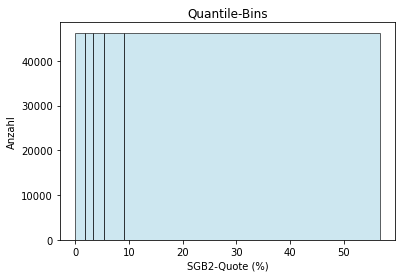

Bin 1: 0.00-1.82, Anzahl: 46260
Bin 2: 1.82-3.32, Anzahl: 46260
Bin 3: 3.32-5.35, Anzahl: 46260
Bin 4: 5.35-9.07, Anzahl: 46260
Bin 5: 9.07-56.68, Anzahl: 46259


In [22]:
# Anzahl der Bins
num_bins = 5

# Quantile berechnen
quantiles = np.linspace(0, 1, num_bins + 1)
bin_edges = np.quantile(stacked_lb_bev_ue70['SGB2-Quote (%)'], quantiles)

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue70['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Quantile-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue70['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue70['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Gleichmaessige Intervalle__: Hierbei wird der gesamte Bereich der Daten in gleich grosse Intervalle unterteilt. Diese Einteilung ist leicht verstaendlich, kann jedoch dazu fuehren, dass viele Datenpunkte in ein oder zwei Bins fallen, wenn die Daten stark ungleich verteilt sind.

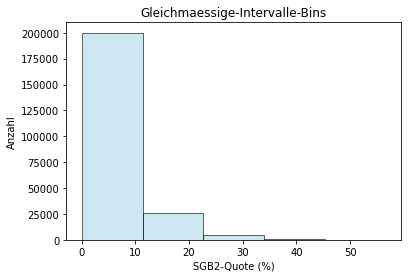

Bin 1: 0.00-11.34, Anzahl: 200049
Bin 2: 11.34-22.67, Anzahl: 26101
Bin 3: 22.67-34.01, Anzahl: 4556
Bin 4: 34.01-45.34, Anzahl: 547
Bin 5: 45.34-56.68, Anzahl: 46


In [23]:
# Anzahl der Bins
num_bins = 5

# Gleichmaessige Intervalle berechnen
bin_edges = np.linspace(stacked_lb_bev_ue70['SGB2-Quote (%)'].min(), stacked_lb_bev_ue70['SGB2-Quote (%)'].max(), num_bins + 1)

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue70['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Gleichmaessige-Intervalle-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue70['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue70['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Standardabweichung__: Hierbei werden Bins basierend auf der statistischen Standardabweichung der Daten erstellt. Dies kann hilfreich sein, um zu sehen, welche Datenpunkte signifikant vom Durchschnitt abweichen.

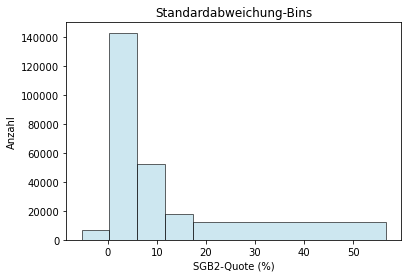

Bin 1: -5.34-0.32, Anzahl: 6538
Bin 2: 0.32-5.98, Anzahl: 142734
Bin 3: 5.98-11.63, Anzahl: 52267
Bin 4: 11.63-17.29, Anzahl: 17701
Bin 5: 17.29-56.68, Anzahl: 12059


In [24]:
# Anzahl der Bins
num_bins = 5

# Standardabweichung berechnen
mean = stacked_lb_bev_ue70['SGB2-Quote (%)'].mean()
std = stacked_lb_bev_ue70['SGB2-Quote (%)'].std()
bin_edges = [mean - 2*std, mean - std, mean, mean + std, mean + 2*std, stacked_lb_bev_ue70['SGB2-Quote (%)'].max()]

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue70['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Standardabweichung-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(bin_edges)-1):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue70['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue70['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Benutzerdefinierte Bins__:  Hier kann der Benutzer die Bins manuell festlegen, auf Grundlage seines Wissens ueber die Struktur der Daten, fachlicher Erwaegungen, seiner Anforderungen an die Visualisierung etc.

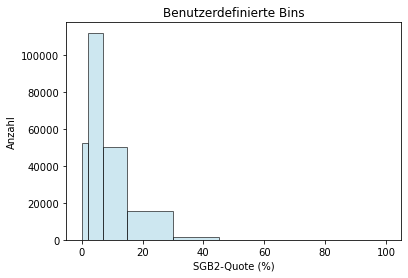

Bin 1: 0-2, Anzahl: 52137
Bin 2: 2-7, Anzahl: 111876
Bin 3: 7-15, Anzahl: 50036
Bin 4: 15-30, Anzahl: 15810
Bin 5: 30-45, Anzahl: 1390
Bin 6: 45-100, Anzahl: 51


In [25]:
# Benutzerdefinierte Bins festlegen
custom_bins = [0, 2, 7, 15, 30, 45, 100]

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue70['SGB2-Quote (%)'], bins=custom_bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Benutzerdefinierte Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(custom_bins)-1):
    bin_range = f'{custom_bins[i]}-{custom_bins[i+1]}'
    count = ((stacked_lb_bev_ue70['SGB2-Quote (%)'] >= custom_bins[i]) & (stacked_lb_bev_ue70['SGB2-Quote (%)'] < custom_bins[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Natural-Breaks-Bins__: Die Methode Natural Breaks klassifiziert die Datenpunkte in Klassen basierend auf natuerlichen Gruppen in den Daten selbst. Sie versucht, die Varianz innerhalb der Gruppen zu minimieren und die Varianz zwischen den Gruppen zu maximieren.

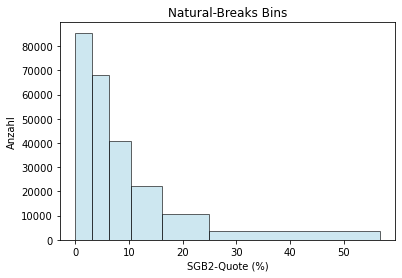

Bin 1: 0.0-3.0817291455589335, Anzahl: 82165
Bin 2: 3.0817291455589335-6.261164701679174, Anzahl: 68224
Bin 3: 6.261164701679174-10.402429764616548, Anzahl: 40735
Bin 4: 10.402429764616548-16.182795698924732, Anzahl: 22402
Bin 5: 16.182795698924732-24.807321772639636, Anzahl: 10714
Bin 6: 24.807321772639636-56.67892156862743, Anzahl: 3635


In [26]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev_ue70['SGB2-Quote (%)'].values

# Berechnen der Bins mit der NaturalBreaks-Methode
classifier = NaturalBreaks(data, k=6)
breaks = classifier.bins
breaks = np.insert(breaks, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=breaks, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Natural-Breaks Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(breaks)-1):
    print(f"Bin {i+1}: {breaks[i]}-{breaks[i+1]}, Anzahl: {((data > breaks[i]) & (data <= breaks[i+1])).sum()}")

__FisherJenks_ bzw. FisherJenksSampled__: Aehnlich wie Natural Breaks, jedoch spezialisiert auf die Anwendung auf eindimensionale Daten; sorgt im Vergleich zu aehnlichen Methoden für geringere Abweichungen der Datenpunkte um den jeweiligen Klassen-Median. Bei der "Sampled"-Variante (sinnvoll bei sehr grossen Datenmengen) werden nicht alle Datenpunkte, sondern eine Stichprobe (z. B. 20 % der Faelle) zur Ermittlung der Klassengrenzen beruecksichtigt. 

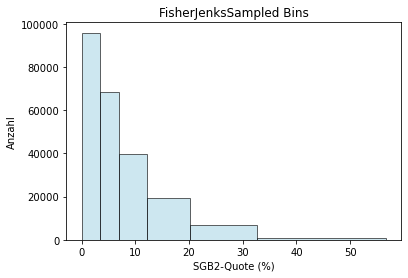

Bin 1: 0.0-3.4438775510204076, Anzahl: 92434
Bin 2: 3.4438775510204076-7.026645383104127, Anzahl: 68496
Bin 3: 7.026645383104127-12.178387650085764, Anzahl: 39782
Bin 4: 12.178387650085764-20.199674001629976, Anzahl: 19527
Bin 5: 20.199674001629976-32.59009009009008, Anzahl: 6816
Bin 6: 32.59009009009008-56.67892156862743, Anzahl: 820


In [27]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev_ue70['SGB2-Quote (%)'].values

# Berechnen der Bins mit der FisherJenksSampled-Methode
classifier = FisherJenksSampled(data, pct=0.2, k=6)
bins = classifier.bins
bins = np.insert(bins, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('FisherJenksSampled Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(bins)-1):
    print(f"Bin {i+1}: {bins[i]}-{bins[i+1]}, Anzahl: {((data > bins[i]) & (data <= bins[i+1])).sum()}")

### 3.10 Bins fuer 2021 auf Gemeindeebene mit FisherJenks-Methode ermitteln

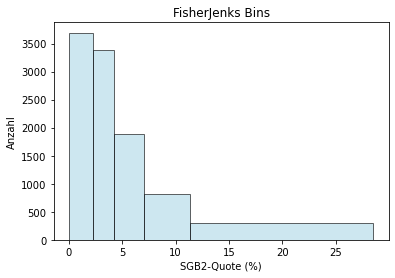

Bin 1: 0.0-2.226947179946283, Anzahl: 3613
Bin 2: 2.226947179946283-4.244913928012523, Anzahl: 3387
Bin 3: 4.244913928012523-7.0093829516539445, Anzahl: 1885
Bin 4: 7.0093829516539445-11.334548539459805, Anzahl: 819
Bin 5: 11.334548539459805-28.51718625099912, Anzahl: 306


In [28]:
# Daten bereinigen, sodass zusammengefasste SGB2-Quote auf Gemeindeebene fuer das Jahr 2021 verbleibt
data2021_fisher_jenks = stacked_lb_bev_ue70
data2021_fisher_jenks = data2021_fisher_jenks[data2021_fisher_jenks.Jahr == 2021]
data2021_fisher_jenks['LB_Gesamt'] = data2021_fisher_jenks.groupby('Gemeinde')['Anzahl_LB'].transform('sum')
data2021_fisher_jenks['Bev_Gesamt'] = data2021_fisher_jenks.groupby('Gemeinde')['Anzahl_Bevoelkerung'].transform('sum')
data2021_fisher_jenks["SGB2-Quote (%) gesamt"] = (data2021_fisher_jenks["LB_Gesamt"] / data2021_fisher_jenks["Bev_Gesamt"]) * 100
data2021_fisher_jenks = data2021_fisher_jenks[['Gemeinde', 'SGB2-Quote (%) gesamt']]
data2021_fisher_jenks = data2021_fisher_jenks.drop_duplicates()

# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%) gesamt'
data = data2021_fisher_jenks['SGB2-Quote (%) gesamt'].values

# Berechnen der Bins mit der FisherJenks-Methode
classifier = FisherJenks(data, k=5)
bins = classifier.bins
bins = np.insert(bins, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('FisherJenks Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(bins)-1):
    print(f"Bin {i+1}: {bins[i]}-{bins[i+1]}, Anzahl: {((data > bins[i]) & (data <= bins[i+1])).sum()}")

### 3.11 Bins-Spalte ergaenzen

In [29]:
# Grenzen und Labels fuer die Bins (basierend auf FisherJenks) definieren
bins = [0, 2, 4, 7, 11, 100]
labels = [1, 2, 3, 4, 5]

# Neue 'bins'-Spalte erstellen
stacked_lb_bev_ue70['bins'] = pd.cut(stacked_lb_bev_ue70['SGB2-Quote (%)'], bins=bins, labels=labels)

### 3.12 Problem beheben, das durch 7-stellige AGS entsteht

In [30]:
# Spalte "AGS" als String definieren
stacked_lb_bev_ue70["AGS"] = stacked_lb_bev_ue70["AGS"].astype(str)

# "0" vor den Eintraegen mit genau 7 Zeichen hinzufuegen
stacked_lb_bev_ue70["AGS"] = stacked_lb_bev_ue70["AGS"].apply(lambda x: '0' + x if len(x) == 7 else x)

### 3.13 AGS fuer Kreisebene ergaenzen

In [31]:
stacked_lb_bev_ue70['AGS_Kreis'] = stacked_lb_bev_ue70['AGS'].str[:5]

### 3.14 AGS fuer Bundesland ergaenzen

In [32]:
stacked_lb_bev_ue70['AGS_BL'] = stacked_lb_bev_ue70['AGS'].str[:2]

### 4. Tabellen exportieren als Excel und CSV

In [33]:
# DataFrame stacked_elb_schul speichern
stacked_elb_schul_ue70.to_excel('elb_quote_schul_ue70.xlsx', index=False)
stacked_elb_schul_ue70.to_csv('elb_quote_schul_ue70.csv', index=False)

# DataFrame stacked_elb_beruf speichern
stacked_elb_beruf_ue70.to_excel('elb_quote_beruf_ue70.xlsx', index=False)
stacked_elb_beruf_ue70.to_csv('elb_quote_beruf_ue70.csv', index=False)

# DataFrame stacked_lb_bev speichern
stacked_lb_bev_ue70.to_excel('sgb2_quote_ue70.xlsx', index=False)
stacked_lb_bev_ue70.to_csv('sgb2_quote_ue70.csv', index=False)